In [111]:
import numpy as np
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt
import matplotlib.image as image
plt.rcParams["figure.figsize"] = (5,3)

In [112]:
def moving_average(array, interval=50):
    sliding_score = np.zeros(len(array))
    for t in range(len(array)):
        sliding_score[t] = np.mean(array[max(0,t-interval):(t+1)])
    return sliding_score

In [141]:
class QLearning:
    def __init__(self, 
                 n_epochs=1000, 
                 eps=1, 
                 eps_decay_type='lin',
                 alpha=0.4, 
                 gamma=0.9,
                 eps_decay=0.999):
        
        # lookup matrix (pos.x, pos.y, coin_flag, value corresp to action)
        self.Q = np.zeros(shape=(env.field.shape[0], env.field.shape[1], 2, 4)) # np.array of the field's shape
        self.eps = eps # epsilon as in epsilon-greedy policy
        self.eps_decay = eps_decay # ???
        self.eps_decay_type = eps_decay_type
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.n_epochs = n_epochs
    
    def update_Q(self, s_t, f, a_t, reward, s_next, f_next):
        self.Q[s_t[0], s_t[1], f, a_t] += self.alpha * \
                    (reward + self.gamma*np.max(self.Q[s_next[0], s_next[1], f]) - self.Q[s_t[0], s_t[1], f, a_t])
    
    def get_best_action(self, s_t, f):
        return np.argmax(self.Q[s_t[0], s_t[1], f])
    
    def train(self, env):
        self.env = env
        self.scores = np.zeros(self.n_epochs)
        self.eps_vals = np.zeros(self.n_epochs)
        self.coins_collected = np.zeros(self.n_epochs)
        for epoch in tqdm(range(self.n_epochs)):
            s_t, f_t = self.env.reset()
            done = False
            score = 0
            while not done:
                action = self.env.action_space.sample() if np.random.random() < self.eps else self.get_best_action(s_t, f_t)
                (s_next, f_next), reward, done, info = self.env.step(action)
#                 print(s_next, f, reward, done, info)
                self.update_Q(s_t, f_t, action, reward, s_next, f_next)
                s_t = s_next
                f_t = f_next
                score += reward
            
            self.coins_collected[epoch] = sum(self.env.is_coin_collected.values())
            self.scores[epoch] = score
            
            if self.eps_decay_type == 'lin':
                self.eps -= 1/(self.n_epochs) if self.eps > 0.01 else 0 # linear
            elif self.eps_decay_type == 'exp':
                self.eps *= self.eps_decay if self.eps > 0.15 else 1 # exponential
            else:
                raise Exception('Unknown eps decay type specifier:', self.eps_decay_type)
            self.eps_vals[epoch] = self.eps
    
    def solve(self):
        s, f = self.env.reset()
        e = self.env.exits
        path = []
        cnt = 0
        while s not in e:
            path.append(s)
            action = self.get_best_action(s, f)
            (s, f), _, _, _ = self.env.step(action)
            cnt+=1
            if cnt > self.env.WIDTH * self.env.HEIGHT:
                raise Exception('Agent failed to converge')
        return path[1:]


## Init and training

In [142]:
img = image.imread('tracks/track2.png')[:,:,:3]

In [143]:
%run maze_RL.ipynb
env = MazeEnvironment(img)

D:\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


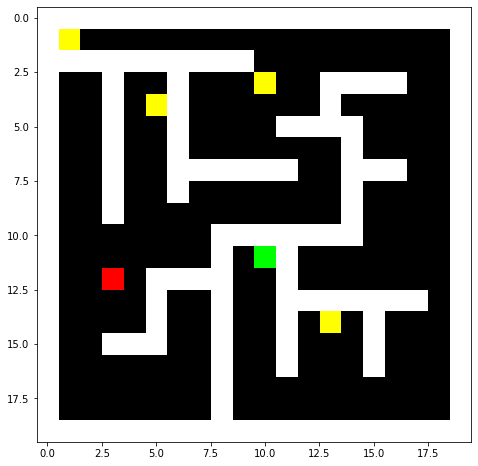

In [144]:
env.render()

In [145]:
env.reset()

((12, 3), 0)

In [146]:
model = QLearning(n_epochs=15000) #, eps=1, eps_decay=0.99, alpha=0.5)

In [147]:
model.train(env)

100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:11<00:00, 1363.04it/s]


In [149]:
model.Q[4,4,0]

array([0., 0., 0., 0.])

In [150]:
env.coins

{(1, 1), (3, 10), (4, 5), (14, 13)}

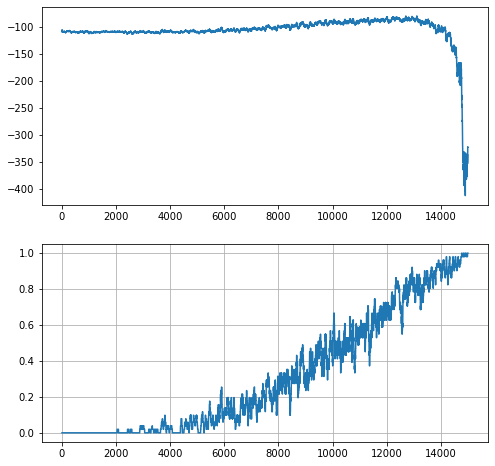

In [151]:
fig, axs = plt.subplots(2)
axs[0].plot(moving_average(model.scores))
axs[1].plot(moving_average(model.coins_collected))
plt.grid()
plt.show()

In [134]:
env.reset()

((12, 3), 0)

In [135]:
optimal_path = model.solve()

Exception: Agent failed to converge

In [110]:
env.render(model, show_labels=False)

Exception: Agent failed to converge

with open('weights/track2_fucker_collects_one_single_coin.pickle', 'wb') as f:
    pickle.dump(model, file=f)

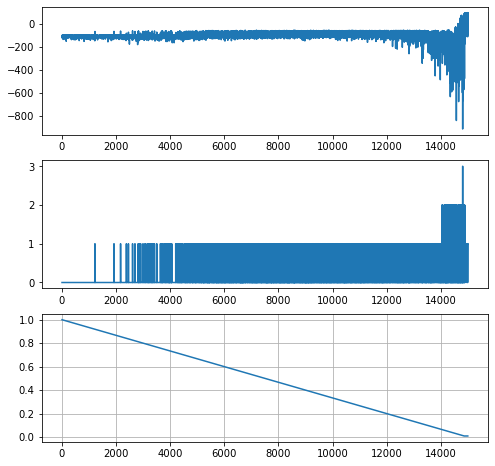

In [19]:
fig, axs = plt.subplots(3)
axs[0].plot(model.scores)
axs[1].plot(model.coins_collected)
axs[2].plot(model.eps_vals)
plt.grid()
plt.show()